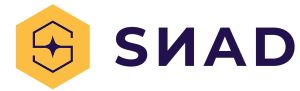

# Adaptive Anomaly Detection Tutorial

This tutorial shows how to use the [coniferest](https://github.com/snad-space/coniferest) package, which was developed by the [SNAD team](https://snad.space/).


Full documentation can be found [ReadTheDocs](https://coniferest.readthedocs.io/en/latest/).


Developers:  
[Konstantin Malanchev (UIUC)](https://homb.it/)  
[Matwey Kornilov (MSU)](https://github.com/matwey)  
[Vladimir Korolev](https://www.linkedin.com/in/vladimir-korolev-a4195b86/)  



In [4]:
!pip install -U coniferest

In [5]:
import matplotlib.pyplot as plt
from coniferest.datasets import non_anomalous_outliers
from coniferest.label import Label
import numpy as np

# Load Features (for the TDE example)


In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

def load_from_drive():

  tdes = pd.read_csv('/content/drive/MyDrive/rainbow_features_all_tde_in_ztf_fixed_temperature.csv')
  simbad = pd.read_csv('/content/drive/MyDrive/rainbow_features_all_simbad_fixed_temperature.csv', index_col=0)
  tns = pd.read_parquet('/content/drive/MyDrive/rainbow_features_tns_201911_202103.parquet')
  simbad['type'] = 'simbad'
  tns['type'] = 'tns'

  all_features = pd.concat([tdes, simbad, tns])

  # Shuffle dataframe
  df = all_features.sample(frac = 1).reset_index(drop=True)
  # Get array with type of objects
  metadata = df.type.to_numpy()

  # Remove not scalar columns
  df = df.loc[:, (df.columns!='id') & (df.columns!='type') & (df.columns !='objectId')]

  # Remove t0 !!
  df = df.loc[:,  (df.columns != 't0') & (df.columns != 't0_err')]

  return df, metadata

In [7]:
def load_from_github():
  url_all_features = 'https://raw.githubusercontent.com/Miguel-LlamasLanza/early_tde_classification/main/anomaly_detection/features_all.csv'

  features = pd.read_csv(url_all_features)
  # Shuffle dataframe
  df = features.sample(frac = 1).reset_index(drop=True)
  # Get array with type of objects
  # metadata = df['type'].to_numpy()
  metadata = df['data_origin'].to_numpy()

  # Remove not scalar columns (and other extra columns)
  df = df.loc[:, (df.columns!='alertId') & (df.columns!='type') & (df.columns !='objId') & (df.columns !='data_origin')]
  df = df.loc[:, (df.columns!='ref_time') & (df.columns!='err_ref_time')]

  return df, metadata

In [8]:
import pandas as pd

from_drive = False

if from_drive:
  df, labels = features = load_from_drive()
else:
  df, labels = load_from_github()
  labels[labels == 'tdes_ztf'] = 'TDE'


feat_data_to_fit = df.to_numpy()  # This is 2d np.array. What is used in this notebook


# Example: non-active anomaly detection¶

Let’s run Isolation Forest model (see [Liu *et al.* 2008](https://doi.org/10.1109/ICDM.2008.17)) on the data we just created:

In [9]:
from coniferest.datasets import single_outlier
from coniferest.isoforest import IsolationForest

# declare and fit an isolation forest
model_iso = IsolationForest(random_seed=0)
model_iso.fit(feat_data_to_fit)

# evaluate classification
scores_iso = model_iso.score_samples(feat_data_to_fit)



---

The coniferest implementation of isolation forest is up to 100x faster than the scikit-learn one. See performance tests [here](https://coniferest.readthedocs.io/en/latest/isoforest.html).

---



### Check the distribution of anomaly scores

In [10]:
mask_tdes = labels == 'TDE'
mask_others = labels != 'TDE'

mask_tns = labels == 'tns'
mask_simbad = labels == 'simbad'


In [11]:
def plot_hists(scores, mask_tdes, mask_tns, mask_simbad):
  fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize = (15, 4))

  # Histograms
  ax1.hist(scores, bins=25, label = 'total', color = 'grey', histtype='step', lw = 1)
  # plt.hist(scores[mask_others], bins=25, color = '#15284F', label = 'non TDEs', alpha = 0.5)
  ax1.hist(scores[mask_simbad], bins=25, color = 'green', label = 'Simbad', alpha = 0.4)
  ax1.hist(scores[mask_tns], bins=25, color = 'blue', label = 'TNS', alpha = 1)
  ax1.hist(scores[mask_tdes], bins=25, color = 'red', label = 'TDEs', alpha = 1)
  # Set-up
  ax1.set_xlabel('anomaly scores', fontsize=14)
  ax1.set_ylabel('N', fontsize=14)
  ax1.legend()
  ax1.set_yscale('log')

  # --- Second plot ---

  # Histograms
  ax2.hist(scores, bins=25, label = 'total', color = 'grey', histtype='step', lw = 1)
  ax2.hist(scores[mask_simbad], bins=25, color = 'green', label = 'Simbad', alpha = 0.4)
  ax2.hist(scores[mask_tns], bins=25, color = 'blue', label = 'TNS')
  ax2.hist(scores[mask_tdes], bins=25, color = 'red', label = 'TDEs')
  # Set-up
  ax2.set_xlabel('anomaly scores', fontsize=14)
  ax2.legend()

  # --- Third plot ---

  # Histograms
  ax3.hist(scores, bins=25, label = 'total', color = 'grey', histtype='step', lw = 1)
  ax3.hist(scores[mask_simbad], bins=25, color = 'green', label = 'Simbad', alpha = 0.4)
  ax3.hist(scores[mask_tns], bins=25, color = 'blue', label = 'TNS')
  ax3.hist(scores[mask_tdes], bins=25, color = 'red', label = 'TDEs')
  # Set-up
  ax3.set_xlabel('anomaly scores', fontsize=14)
  ax3.set_ylim(top = 600)
  ax3.legend()



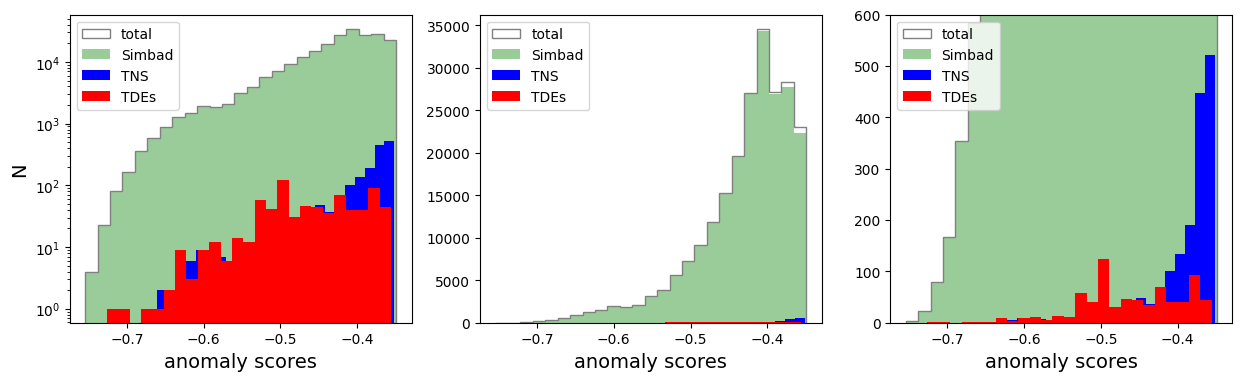

In [12]:
plot_hists(scores_iso, mask_tdes, mask_tns, mask_simbad)

In [13]:
len(scores_iso[mask_tdes]), len(scores_iso[mask_tns]), len(scores_iso[mask_simbad])

(737, 1703, 223968)

In [14]:
# Save scores to file in Github
df_scores_iso = pd.DataFrame(np.column_stack([scores_iso, labels]), columns = ['scores', 'labels'])
df_scores_iso.to_csv('scores_iso.csv', index = False)


In [15]:
# Get total percentage population
simbad_total = len(scores_iso[mask_simbad]) / len(scores_iso)
tns_total = len(scores_iso[mask_tns]) / len(scores_iso)
tdes_total = len(scores_iso[mask_tdes]) / len(scores_iso)

data_total = [simbad_total, tns_total, tdes_total]


def get_percentages_above_treshold(scores, score_thresh):
  # Get percentages of each population above threshold (Make this as a funtion)
  simbad_above = np.sum(scores[mask_simbad] < score_thresh) / np.sum(scores < score_thresh)
  tns_above = np.sum(scores[mask_tns] < score_thresh) / np.sum(scores < score_thresh)
  tdes_above = np.sum(scores[mask_tdes] < score_thresh) / np.sum(scores < score_thresh)

  false_positive = np.sum(scores[mask_others] < score_thresh) / len(scores[mask_others])
  false_negative = np.sum(scores[mask_tdes] > score_thresh) / len(scores[mask_tdes])

  data = [[simbad_above, tns_above, tdes_above,
          false_positive, false_negative]]


  df = pd.DataFrame(data = data,
                    columns = ['Simbad above thresh', 'TNS above thresh', 'TDEs above thresh',
                              'non TDEs above thresh', 'TDEs below thresh' ])
  return df

df_iso = get_percentages_above_treshold(scores_iso, -0.5)
df_iso


,Simbad above thresh,TNS above thresh,TDEs above thresh,non TDEs above thresh,TDEs below thresh
0,0.990872,0.002806,0.006322,0.123977,0.75848



## Test with Active anomaly detection (tune the AD algorithm to your definition of anomaly)

In [16]:
from coniferest.pineforest import PineForest

# declare the model parameters
model_ex1 = PineForest(
    # Use 1024 trees, a trade-off between speed and accuracy
    n_trees=1024,
    # Fix random seed for reproducibility
    random_seed=None,
)


In [17]:
index = labels == 'TDE'
labels_integer = (labels == 'TDE').astype(int)

In [ ]:
from coniferest.session import Session
from coniferest.session.callback import (
    TerminateAfter, prompt_decision_callback,
)
session_ex1 = Session(
    data=feat_data_to_fit,
    metadata=labels_integer,
    model=model_ex1,
    decision_callback=lambda metadata, data, session: metadata,
    on_decision_callbacks=TerminateAfter(300),
)

session_ex1.run()



In [ ]:
scores_pine = session_ex1.model.score_samples(feat_data_to_fit)
# Save
df_scores_pine = pd.DataFrame(np.column_stack([scores_pine, labels]), columns = ['scores', 'labels'])
df_scores_pine.to_csv('scores_pine.csv', index = False)


In [ ]:
plot_hists(scores_iso, mask_tdes, mask_tns, mask_simbad)

In [ ]:
df_pine = get_percentages_above_treshold(scores_pine, -0.5)
df_pine

## ----------------------------
## **Below there are cells not updated, from the original notebook.**
## ----------------------------

In [ ]:
#  See targeted anomalies
session_ex1.known_anomalies

array([1049, 1028, 1053, 1088, 1025, 1041, 1043, 1092, 1040])

In [ ]:
#  See targeted regulars
session_ex1.known_regulars

array([1105])

### Plot your decisions

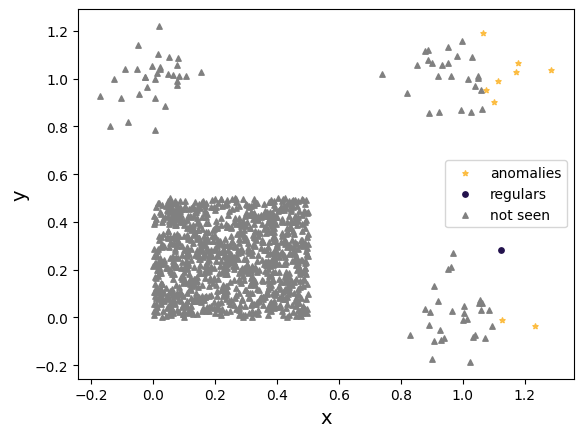

In [ ]:
# flag the objects you decided were anomalous
flag_anomalies = np.isin(metafeat_data_to_fit[:,0].astype(int),
                         session_ex1.known_anomalies)

# flag objects you decided were regulars
flag_regulars = np.isin(metafeat_data_to_fit[:,0].astype(int),
                        session_ex1.known_regulars)

# flag things you did not see
flag_not_seen = np.logical_and(~flag_anomalies, ~flag_regulars)


plt.figure()
plt.scatter(feat_data_to_fit[:,0][flag_anomalies], feat_data_to_fit[:,1][flag_anomalies],
            color='#FCBD43', marker='*', s=15 ,label='anomalies')
plt.scatter(feat_data_to_fit[:,0][flag_regulars], feat_data_to_fit[:,1][flag_regulars],
            color='#22114C', marker='o', s=15, label='regulars')
plt.scatter(feat_data_to_fit[:,0][flag_not_seen], feat_data_to_fit[:,1][flag_not_seen],
            color='gray', marker='^', s=15, label='not seen')
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend()
plt.show()

## Suppose now that you have a set of labels you looked at yesterday ...

In [ ]:
data_ex2, labels_ex2 = non_anomalous_outliers(
    # Number of regular objects
    inliers=1024,
    #  Number of objects per each of three "outlier" classes
    outliers=32,
    # Classification of "outlier" classes
    regions=[Label.R, Label.R, Label.A],
    seed=None
)

In [ ]:
labels_ex2
labels_ex2 == Label.R

array([ True,  True,  True, ..., False, False, False])

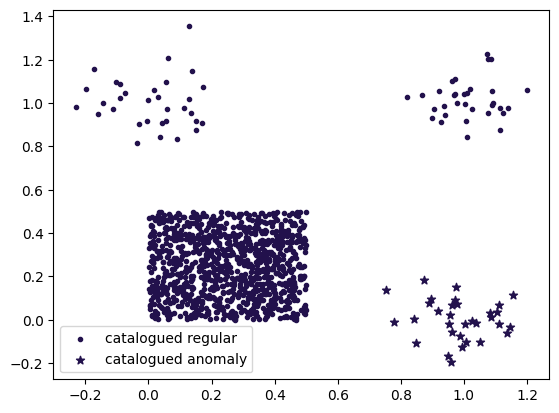

In [ ]:
# Plot the data
index = labels_ex2 == Label.R
plt.scatter(*data_ex2[index, :].T, marker='.', color='#22114C',
            label='catalogued regular')
plt.scatter(*data_ex2[~index, :].T, marker='*', color='#22114C',
            label='catalogued anomaly')
plt.legend()
plt.show()


## Open a session that will read your previous answer and train the model accordingly

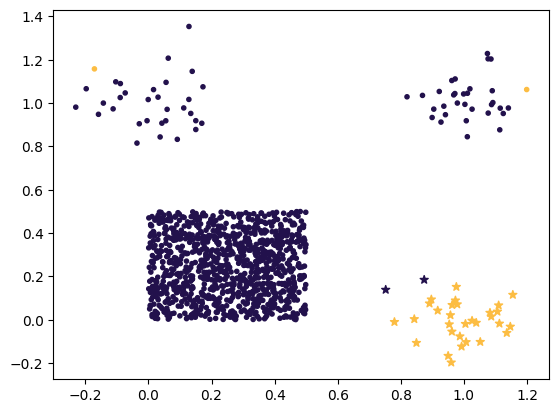

In [ ]:
model_ex2 = PineForest(random_seed=None)

session_ex2 = Session(
    data_ex2,
    metadata=labels_ex2,
    model=model_ex2,
    # metadata consists of true labels, so we can use it as a decision
    decision_callback=lambda metadata, data, session: metadata,
    on_decision_callbacks=TerminateAfter(32),
)
session_ex2.run()

color = np.full_like(labels_ex2, '#22114C', dtype=object)
color[list(session_ex2.known_labels)] = '#FCBD43'

plt.cla()
plt.scatter(*data_ex2[index, :].T, marker='.', color=color[index],
            label='regular')
plt.scatter(*data_ex2[~index, :].T, marker='*', color=color[~index],
            label='anomaly')
plt.show()

### Use the model for ex2 to estimate scores from ex1

In [ ]:
scores_dex1_mex2 = session_ex2.model.score_samples(feat_data_to_fit)

In [ ]:
data_ex2.shape

(1120, 2)

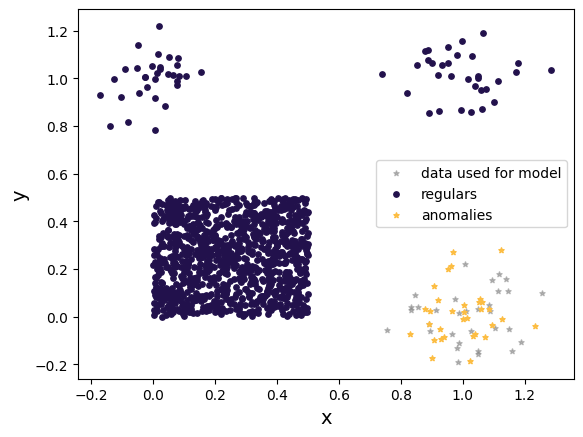

In [ ]:
n_anomalies = 32

indx = scores_dex1_mex2.argsort()     # order objects according to their scores
anomalies = feat_data_to_fit[indx[:n_anomalies]]                   # separate anomalies
regulars = feat_data_to_fit[indx[n_anomalies:]]                     # separate regulars

plt.show()
plt.scatter(*data_ex2[~index, :].T, color='gray', label='data used for model',
            alpha=0.5,s=15, marker="*")
plt.scatter(regulars[:,0], regulars[:,1], color='#22114C', marker='o', s=15,
            label='regulars')
plt.scatter(anomalies[:,0], anomalies[:,1], color='#FCBD43', marker='*', s=15,
            label='anomalies')
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend()
plt.show()

# Example: ZTF light curves of M31 field¶


Let’s use built-in dataset of ZTF light curve features adopted from [Malanchev *et al.* (2021)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.5147M/abstract):

In [ ]:
from coniferest.datasets import ztf_m31

# import built-in data
data_ztf, metadata_ztf = ztf_m31()
print(data_ztf.shape)

(57546, 42)


Here data is 2-D feature dataset (lines are for objects, columns are for features) and metadata is 1-D array of ZTF DR object IDs.

In [ ]:
data_ztf

array([[6.9950008e-01, 2.2794117e-01, 3.6764707e-02, ..., 2.0214492e-01,
        6.6418362e-01, 2.0516939e+01],
       [4.4299984e-01, 2.8888890e-01, 4.4444446e-02, ..., 1.6328827e-01,
        7.9298627e-01, 2.0698317e+01],
       [5.8949947e-01, 2.8000000e-01, 3.2000002e-02, ..., 1.9050223e-01,
        7.2875845e-01, 2.0749649e+01],
       ...,
       [7.3499680e-02, 2.7459016e-01, 4.9180329e-02, ..., 2.4325265e-02,
        7.9307187e-01, 1.7515738e+01],
       [4.3999672e-02, 3.1102362e-01, 7.4803151e-02, ..., 1.6327854e-02,
        7.9121703e-01, 1.5804447e+01],
       [1.9550037e-01, 2.2834645e-01, 5.5118110e-02, ..., 5.5768635e-02,
        7.1393239e-01, 1.8852880e+01]], dtype=float32)

In [ ]:
metadata_ztf

array([695211400017839, 695211400043887, 695211400043454, ...,
       695211200027621, 695211200002462, 695211200070946], dtype=uint64)


Next we need a active anomaly detection model to find outliers in this dataset. Let’s use PineForest model:

In [ ]:
from coniferest.pineforest import PineForest

model_ztf = PineForest(
    # Number of trees to use for predictions
    n_trees=256,
    # Number of new tree to grow for each decision
    n_spare_trees=768,
    # Fix random seed for reproducibility
    random_seed=0,
)


Now we are ready to run active anomaly detection Session:

In [ ]:
from coniferest.session import Session
from coniferest.session.callback import (
    TerminateAfter, viewer_decision_callback,
)

session_ztf = Session(
    data=data_ztf,
    metadata=metadata_ztf,
    model=model_ztf,
    # Prompt for a decision and open object's page on the SNAD Viewer
    decision_callback=viewer_decision_callback,
    on_decision_callbacks=[
        # Terminate session after 10 decisions
        TerminateAfter(10),
    ]
)
session_ztf.run()

Check https://ztf.snad.space/view/695211200075348 for details
Is 695211200075348 anomaly? [y/N]:Check https://ztf.snad.space/view/695211400053697 for details
Is 695211400053697 anomaly? [y/N]: